# 패션비즈니스 10조, "AI 옷 추천의 정당성"
## Basic Settings & Tutorial for CIFAR100
Tutorial code referenced from https://github.com/openai/CLIP

In [1]:
import os
import clip
import torch
from PIL import Image

assert torch.cuda.is_available(), 'GPU not detected'
device = 'cuda'
model, preprocess = clip.load('ViT-B/32', device)


/home/yxxshin/anaconda3/envs/CLIP/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## CIAR100 TUTORIAL
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

image, class_id = cifar100[3637]
print(f'image type: {image}')

image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")


Files already downloaded and verified
image type: <PIL.Image.Image image mode=RGB size=32x32 at 0x7F3FC0059AC0>
           snake: 65.48%
          turtle: 12.11%
    sweet_pepper: 3.87%
          lizard: 1.86%
       crocodile: 1.74%


## Q1. 과연 AI는 "옷을 잘 입는다" 는 의미를 이해할까?
입은 코디에 대한 "피드백"의 PoC 를 검증해보자

옷을 못 입은 코디 사진 12장과, 잘 입은 코디 사진 12장을 준비하였다. 못 입은 코디 사진은 Google 검색어 '패션 테러리스트' 를 통해 얻었고, 잘 입은 코디 사진은 네이버 패션 카페의 '베스트룩' 카테고리에 속한 사진들을 통해 얻었다.

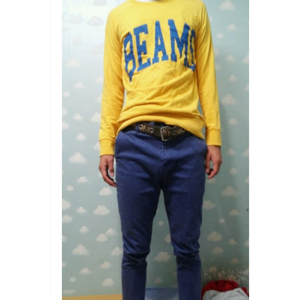

In [3]:
## 못 입은 코디 사진 예시
bad_image_example = Image.open('./bad_outfits/12.png')
display(bad_image_example.resize((300,300)))

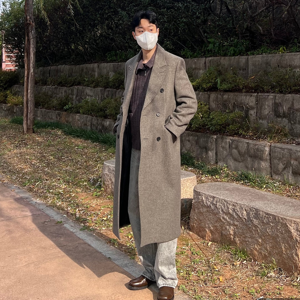

In [4]:
## 잘 입은 코디 사진 예시
good_image_example = Image.open('./good_outfits/12.png')
display(good_image_example.resize((300,300)))

In [73]:
import os
import numpy as np

def eval_outfit_by_folder(folder_path):

    good_score_list = []

    for filename in os.listdir(folder_path):
        # Assume that only image files are inside this path
        file_path = os.path.join(folder_path, filename)
        print(f'Processing {file_path}')

        image = Image.open(file_path)
        image_input = preprocess(image).unsqueeze(0).to(device)
        
        texts = ["a photo of a well-dressed person", "a photo of a person who didn't dress well"]
        text_inputs = torch.cat([clip.tokenize(f"{t}") for t in texts]).to(device)      

        with torch.no_grad():
            image_features = model.encode_image(image_input)
            text_features = model.encode_text(text_inputs)
            
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        print(f'good outfit: {similarity[0][0] * 100}%, bad outfit: {similarity[0][1] * 100}%')
        good_score_list.append(similarity[0][0].detach().cpu() * 100)

    print()
    print(f'Average good outfit score: {np.average(good_score_list)}%')

### 못 입은 코디 12장에 대한 결과

In [74]:
bad_folder_path = './bad_outfits/'
eval_outfit_by_folder(bad_folder_path)

Processing ./bad_outfits/4.jpg
good outfit: 94.75%, bad outfit: 5.26171875%
Processing ./bad_outfits/8.png
good outfit: 52.34375%, bad outfit: 47.65625%
Processing ./bad_outfits/12.png
good outfit: 25.6875%, bad outfit: 74.3125%
Processing ./bad_outfits/6.png
good outfit: 20.6875%, bad outfit: 79.3125%
Processing ./bad_outfits/3.jpg
good outfit: 58.15625%, bad outfit: 41.875%
Processing ./bad_outfits/5.jpg
good outfit: 97.1875%, bad outfit: 2.84375%
Processing ./bad_outfits/2.jpg
good outfit: 23.9375%, bad outfit: 76.0625%
Processing ./bad_outfits/1.png
good outfit: 25.09375%, bad outfit: 74.875%
Processing ./bad_outfits/11.png
good outfit: 10.0859375%, bad outfit: 89.875%
Processing ./bad_outfits/9.png
good outfit: 15.609375%, bad outfit: 84.375%
Processing ./bad_outfits/7.png
good outfit: 62.59375%, bad outfit: 37.375%
Processing ./bad_outfits/10.png
good outfit: 11.7578125%, bad outfit: 88.25%

Average good outfit score: 41.5%


### 잘 입은 코디 12장에 대한 결과

In [75]:
good_folder_path = './good_outfits/'
eval_outfit_by_folder(good_folder_path)

Processing ./good_outfits/8.png
good outfit: 86.0%, bad outfit: 14.0390625%
Processing ./good_outfits/12.png
good outfit: 57.375%, bad outfit: 42.625%
Processing ./good_outfits/6.png
good outfit: 78.8125%, bad outfit: 21.203125%
Processing ./good_outfits/1.png
good outfit: 56.59375%, bad outfit: 43.40625%
Processing ./good_outfits/3.png
good outfit: 77.4375%, bad outfit: 22.546875%
Processing ./good_outfits/2.png
good outfit: 70.875%, bad outfit: 29.09375%
Processing ./good_outfits/11.png
good outfit: 56.96875%, bad outfit: 43.03125%
Processing ./good_outfits/5.png
good outfit: 93.6875%, bad outfit: 6.28125%
Processing ./good_outfits/9.png
good outfit: 77.4375%, bad outfit: 22.546875%
Processing ./good_outfits/7.png
good outfit: 95.0%, bad outfit: 5.03125%
Processing ./good_outfits/4.png
good outfit: 60.40625%, bad outfit: 39.59375%
Processing ./good_outfits/10.png
good outfit: 36.65625%, bad outfit: 63.34375%

Average good outfit score: 70.625%


## Q2. 과연 AI가 해준 추천을 믿을 수 있을까?
상황에 따른 '코디 추천'의 PoC를 검증해 보자.

다양한 상황이 주어질 때, 잘 입은 코디 사진 15개 중에서 "상황에 맞게 잘 입었다"고 AI가 선정한 1~3등과, 사람에게 직접 물었을 때의 결과를 비교하자.

In [63]:
def eval_text_via_folder(text, folder_path):

    top_scores = [0, 0, 0]
    top_filenames = ['','','']

    for filename in os.listdir(folder_path):
        # Assume that only image files are inside this path
        file_path = os.path.join(folder_path, filename)
        image = Image.open(file_path)
        image_input = preprocess(image).unsqueeze(0).to(device)
        text_inputs = clip.tokenize(text).to(device) 

        with torch.no_grad():
            image_features = model.encode_image(image_input)
            text_features = model.encode_text(text_inputs)
            
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T)
        score = similarity.detach().cpu()[0][0]

        if score > top_scores[0]:
            top_scores[2] = top_scores[1]
            top_filenames[2] = top_filenames[1]
            top_scores[1] = top_scores[0]
            top_filenames[1] = top_filenames[0]
            top_scores[0] = score
            top_filenames[0] = filename
        
        elif score > top_scores[1]:
            top_scores[2] = top_scores[1]
            top_filenames[2] = top_filenames[1]
            top_scores[1] = score
            top_filenames[1] = filename
        
        elif score > top_scores[2]:
            top_scores[2] = score
            top_filenames[2] = filename
    
    print(f'1st Place: picture {top_filenames[0]}, score {top_scores[0]}%')
    file_path = os.path.join(folder_path, top_filenames[0])
    display(Image.open(file_path).resize((300,300)))
    print(f'2nd Place: picture {top_filenames[1]}, score {top_scores[1]}%')
    file_path = os.path.join(folder_path, top_filenames[1])
    display(Image.open(file_path).resize((300,300)))
    print(f'3rd Place: picture {top_filenames[2]}, score {top_scores[2]}%')
    file_path = os.path.join(folder_path, top_filenames[2])
    display(Image.open(file_path).resize((300,300)))

1st Place: picture 14.png, score 27.375%


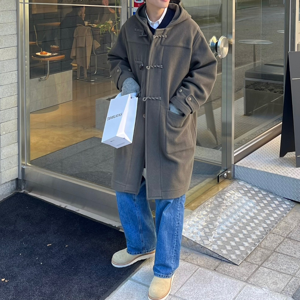

2nd Place: picture 12.png, score 27.328125%


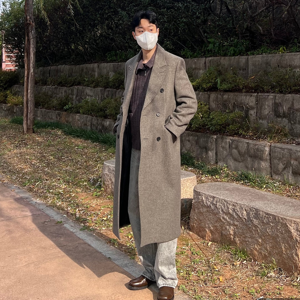

3rd Place: picture 13.png, score 27.234375%


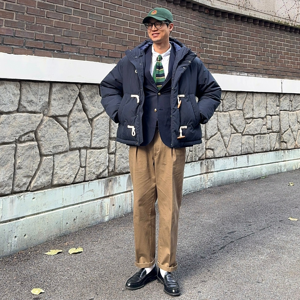

In [64]:
folder_path = './good_outfits_20/'
prompt = 'a photo of an appropriate outfit to wear when going to a museum'
eval_text_via_folder(prompt, folder_path)

1st Place: picture 7.png, score 27.25%


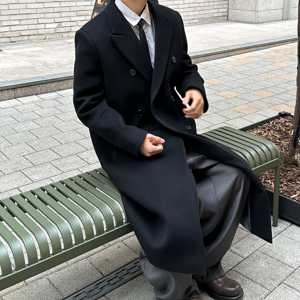

2nd Place: picture 12.png, score 26.671875%


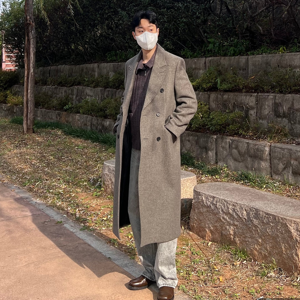

3rd Place: picture 5.png, score 25.296875%


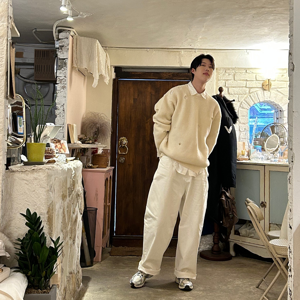

In [65]:
folder_path = './good_outfits_20/'
prompt = 'a photo of an appropriate outfit to wear when going to a wedding'
eval_text_via_folder(prompt, folder_path)

1st Place: picture 10.png, score 26.609375%


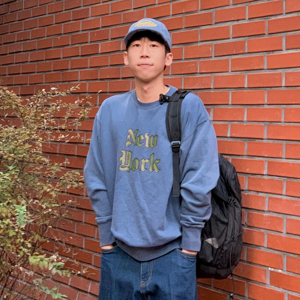

2nd Place: picture 1.png, score 25.65625%


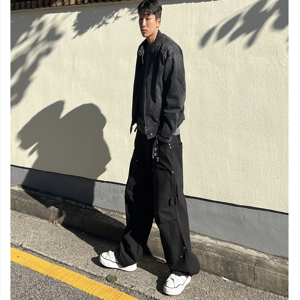

3rd Place: picture 14.png, score 25.15625%


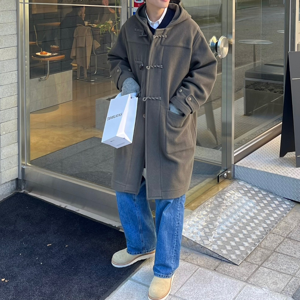

In [66]:
folder_path = './good_outfits_20/'
prompt = 'a photo of an appropriate outfit to wear when going to a game room'
eval_text_via_folder(prompt, folder_path)

1st Place: picture 12.png, score 27.921875%


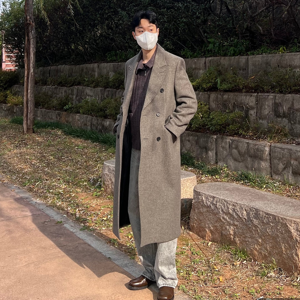

2nd Place: picture 9.png, score 27.84375%


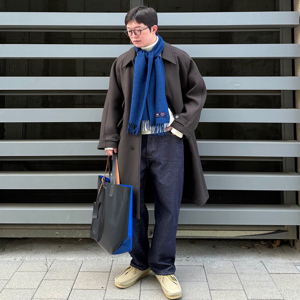

3rd Place: picture 14.png, score 27.59375%


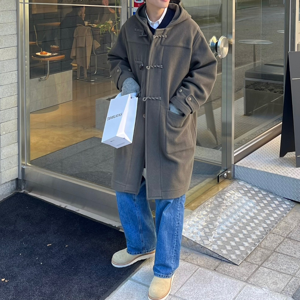

In [72]:
folder_path = './good_outfits_20/'
prompt = 'a photo of an appropriate outfit to wear when going to office'
eval_text_via_folder(prompt, folder_path)